In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, 'models')
sys.path.insert(0, 'utils')
sys.path.insert(1, '../dsvae/yukun_disentanglement_lib/')
import tensorflow_hub as hub
import tensorflow as tf
import yukun_disentanglement_lib
from yukun_disentanglement_lib.data.ground_truth import celeba, celebaHR
import numpy as np
import wandb
import wandb
import matplotlib.pyplot as plt
import numpy as np
import torch
import argparse
from plotting_utils import plot_pytorch_images

from dsvae_model import DSVAE, loss_function
from datasets import DSVAE_DATA

In [2]:
log = False
if log:
    wandb.init(project="pytorch_dsvae", name="celeba_10k_large_grad")

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--z_dim", help="z dimension", default=85, type=int)
parser.add_argument("--device", help="gpu id", default=1, type=int)
parser.add_argument("--nb_epochs", help="number of epochs", default=500, type=int)
parser.add_argument("--start_epoch", help="epoch to start training from (requires checkpoints)", default=0, type=int)
parser.add_argument("--save_interval", help="epochs to save model", default=10, type=int)
parser.add_argument("--run_seed", help="run seed of TCVAE", default=100, type=int)
parser.add_argument("--lr", help="learning rate", default=.0001, type=float)
parser.add_argument("--batch_size", help="batch size", default=100, type=int)
args = parser.parse_args([])

if log:
    wandb.config.update(args)

device = args.device
print("z_dim: {}".format(args.z_dim))
print("GPU: {}".format(device))
print("start_epoch: {}".format(args.start_epoch))
print("save_interval: {}".format(args.save_interval))
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(gpus[args.device], 'GPU')

z_dim: 85
GPU: 1
start_epoch: 0
save_interval: 10


In [4]:
load = True
save = True
num_y_samples = 10
tf.set_random_seed(1)
classifier_url = '../dsvae/tcvae_models/celeba/train_output/100k/d_15_b_15_{}/tfhub/'.format(100)
num_samples=10000
# classifier_url = '../dsvae/tcvae_models/celeba10/train_output/d_15_b_15_{}/tfhub/'.format(0)
print("Classifier URL")
print(classifier_url)
if not load:
    #path to classifier
    classifier = hub.Module(classifier_url)
    dta = celeba.CelebA(celeba_path="../dsvae/yukun_disentanglement_lib/img_align_celeba", num_samples=num_samples)
    ys = np.float32(np.empty((num_samples, num_y_samples, 64, 64,3)))
    with hub.eval_function_for_module(classifier_url) as f:
        for j in range(num_y_samples):
            y = []
            for i in range(10):
                x = np.float32(dta.images[i*int(num_samples/10):(i+1)*int(num_samples/10)])
                y.append(f(dict(images=x), signature="reconstructions", as_dict=True)["images"]) 
            ys[:,j] = np.float32(np.concatenate(y,axis=0))
    inputs = np.float32(dta.images)
    targets = np.float32(ys)
    if save:
        np.save('saved_data/inputs_{}_sample'.format(num_samples), inputs)
        np.save('saved_data/targets_{}_sample'.format(num_samples), targets)     
else:  
    inputs = np.load('saved_data/inputs_{}_sample.npy'.format(num_samples))
    targets = np.load('saved_data/targets_{}_sample.npy'.format(num_samples))

Classifier URL
../dsvae/tcvae_models/celeba/train_output/100k/d_15_b_15_100/tfhub/


In [5]:
torch_inputs = torch.from_numpy(inputs).permute(0,3,1,2)
torch_targets = torch.from_numpy(targets).permute(0,1,4,2,3)

In [6]:
torch_dataset = DSVAE_DATA(torch_inputs, torch_targets)
torch_data_loader = torch.utils.data.DataLoader(torch_dataset, batch_size=args.batch_size, shuffle=True)

In [7]:
if args.device != -1:
    dsvae = DSVAE(z_dim=85, y_shape=[3,64,64], input_shape=[3,64,64], device=args.device)
    dsvae.to(device)
else:
    dsvae = DSVAE(z_dim=85, y_shape=[3,64,64], input_shape=[3,64,64], device=None)
optimizer = torch.optim.Adam(params=dsvae.parameters(), lr=args.lr)

Training for 1500 epochs...


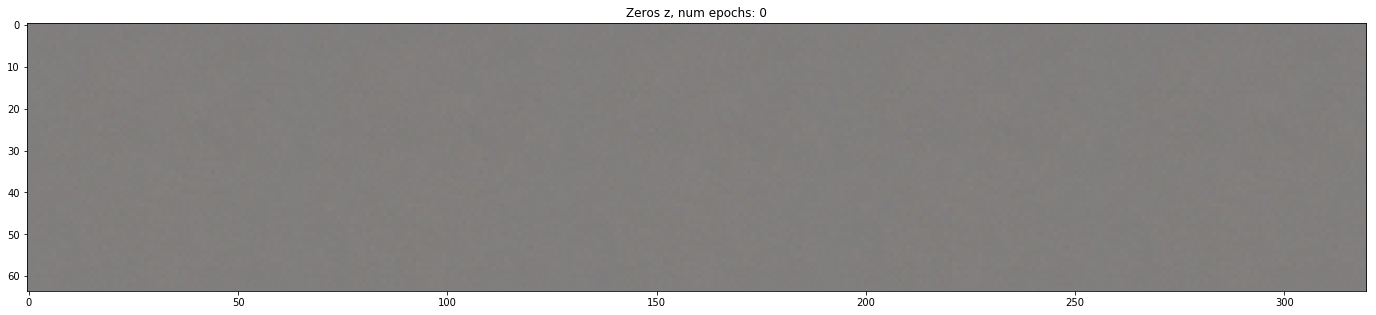

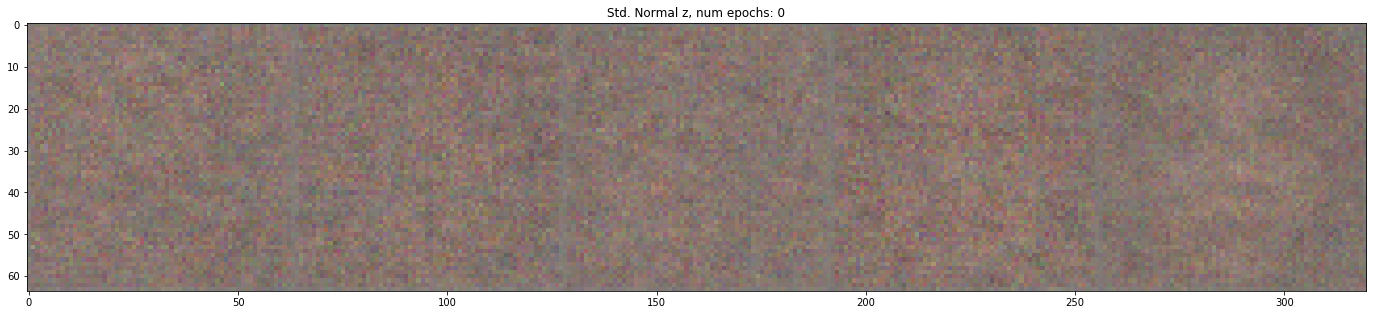

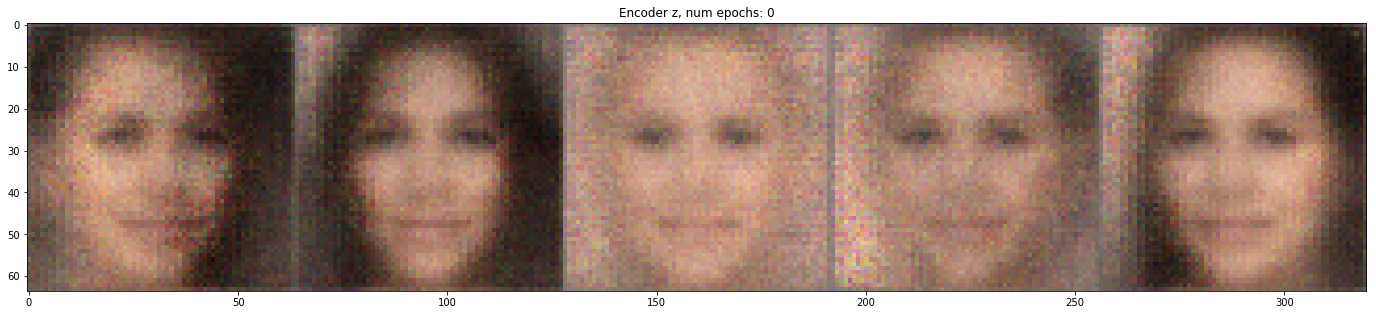

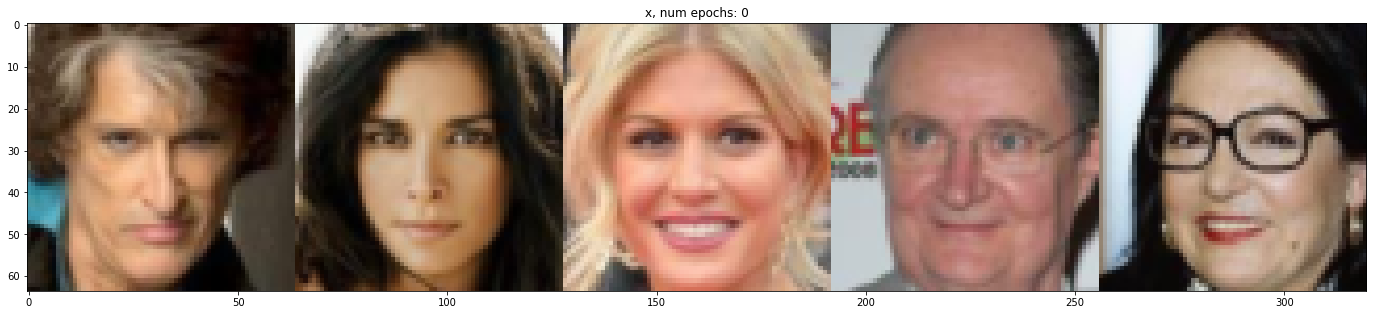

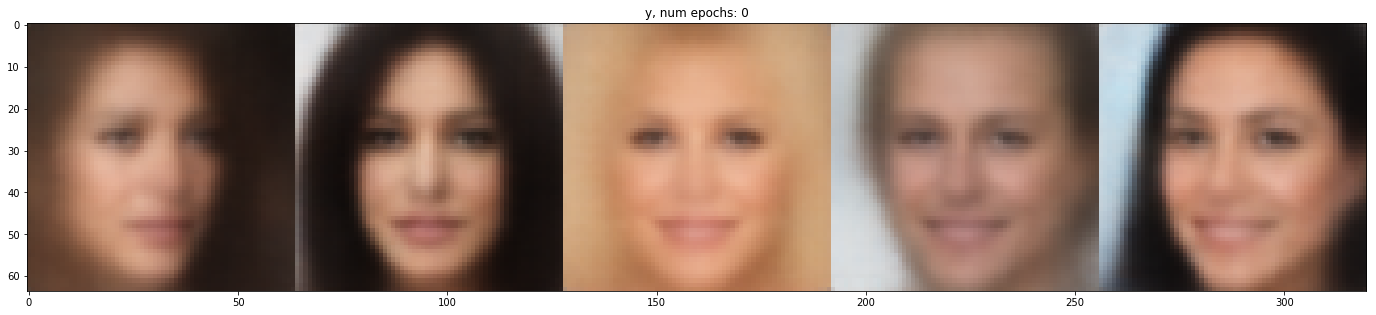

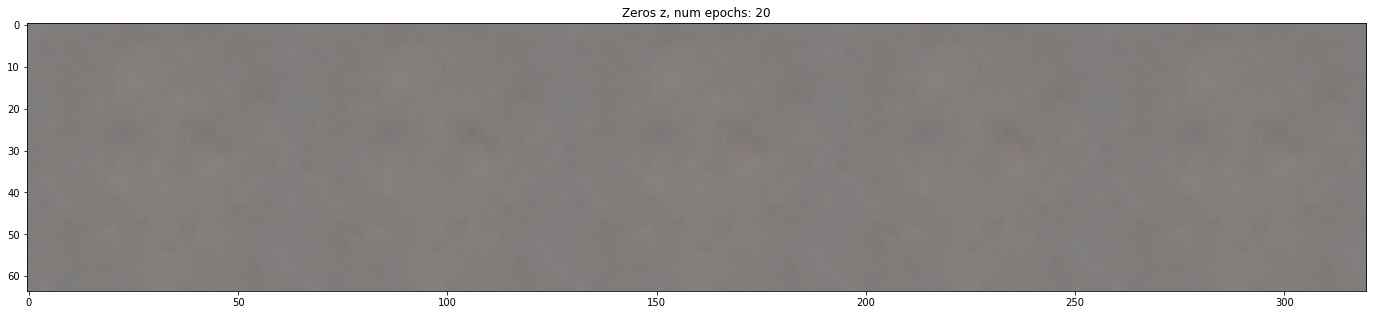

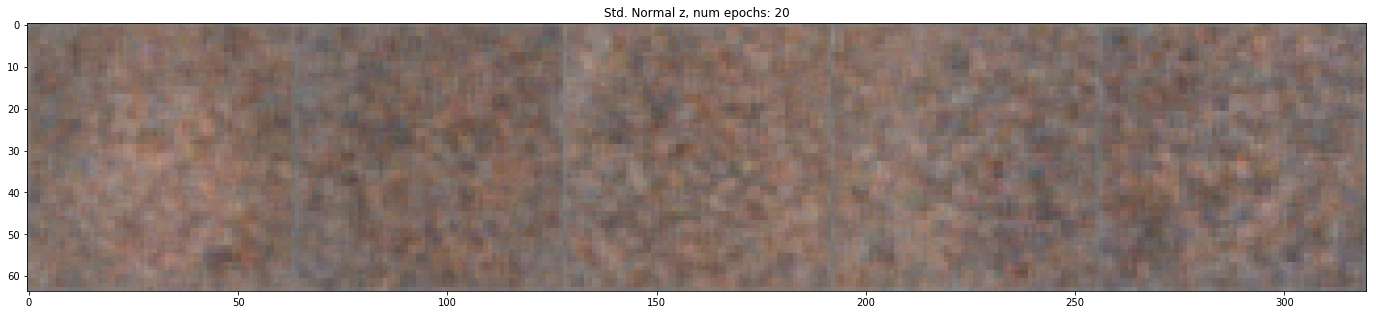

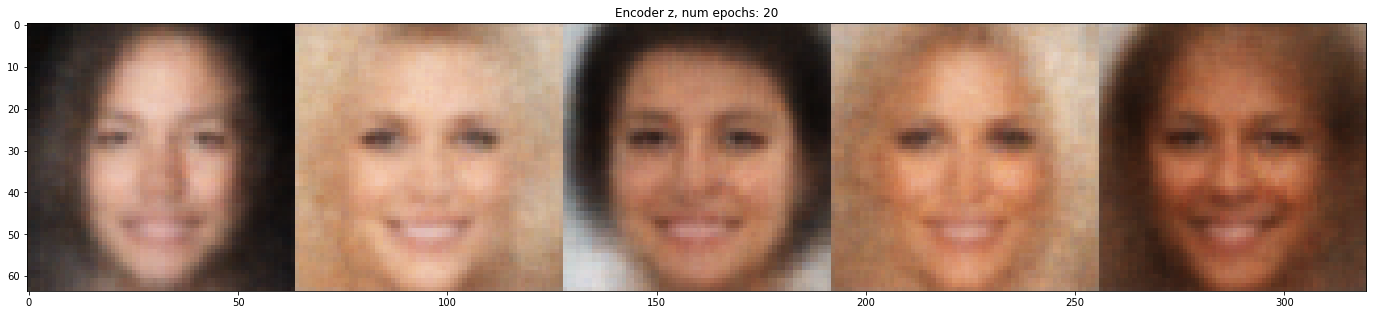

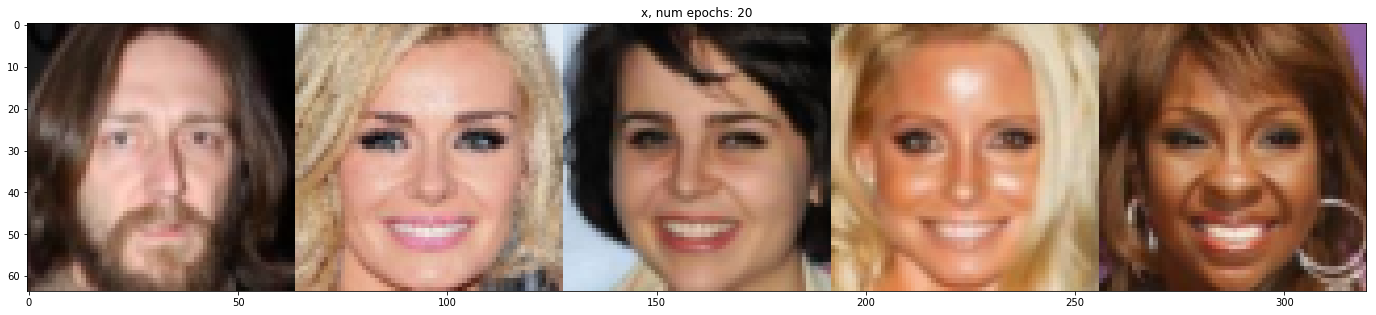

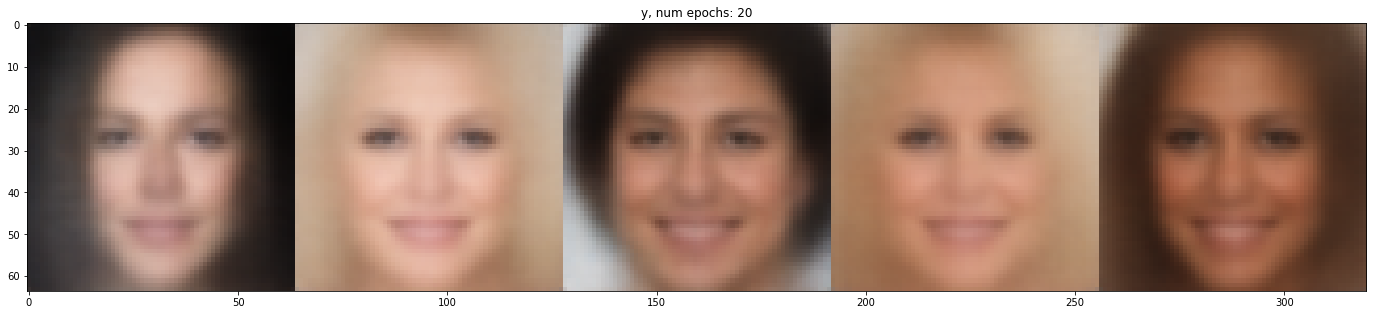

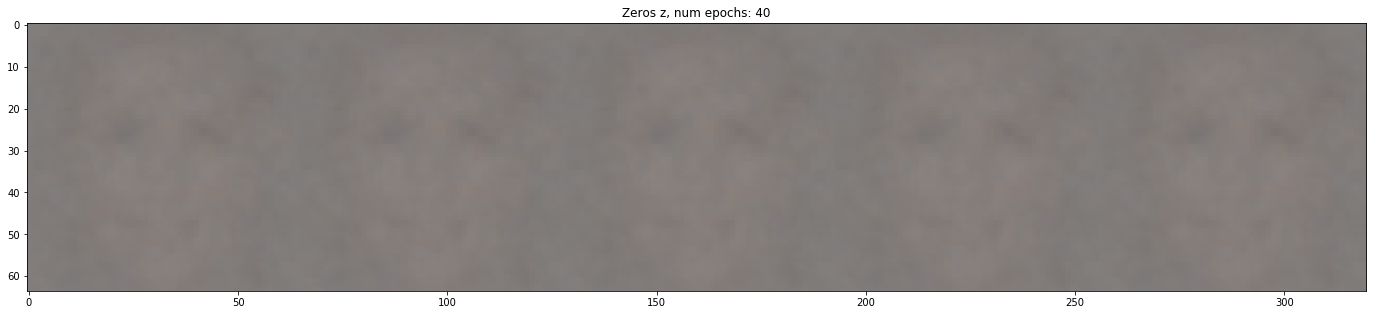

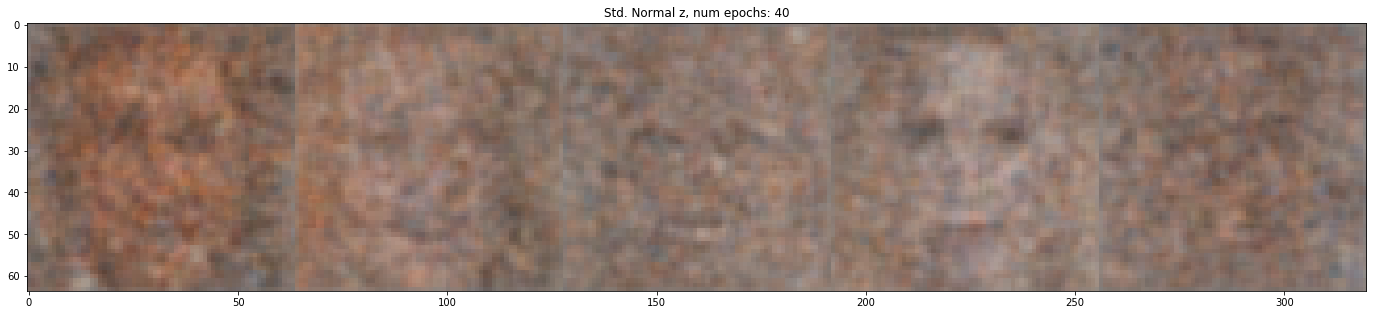

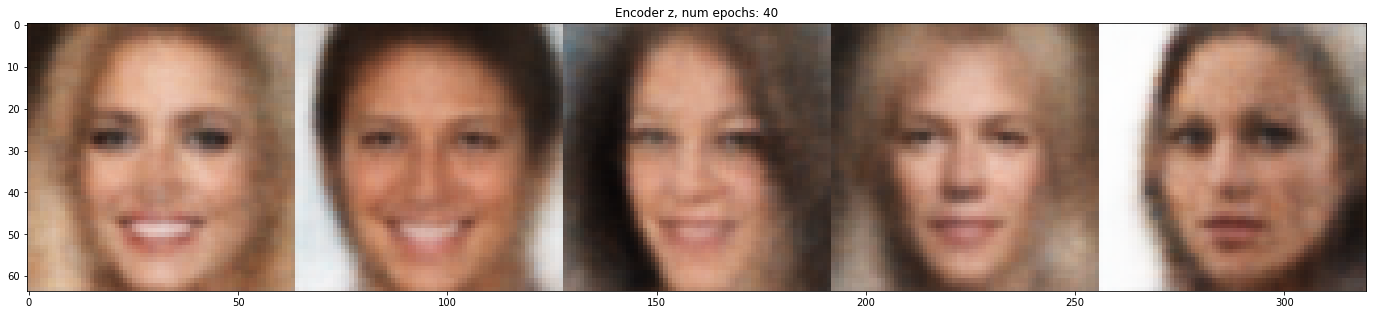

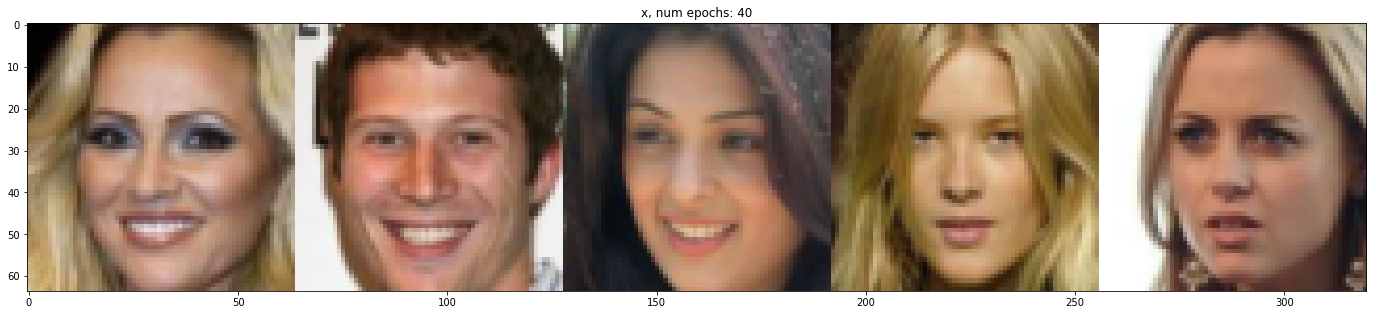

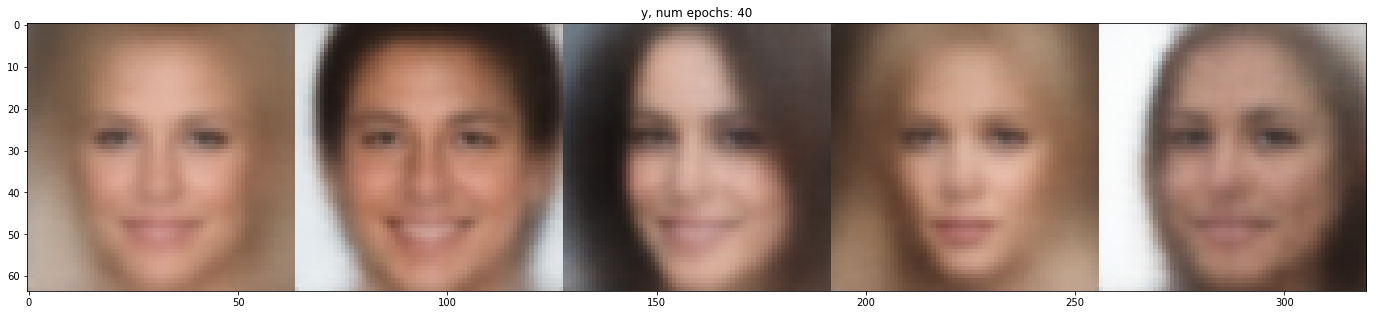

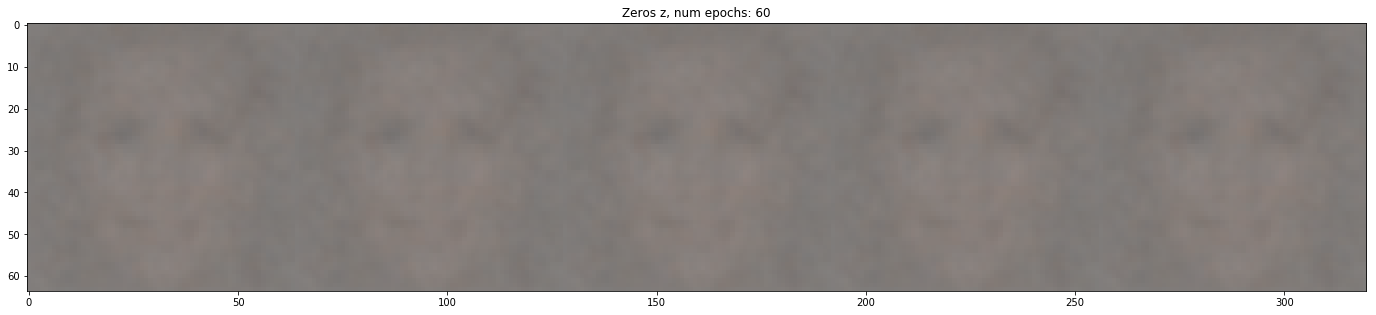

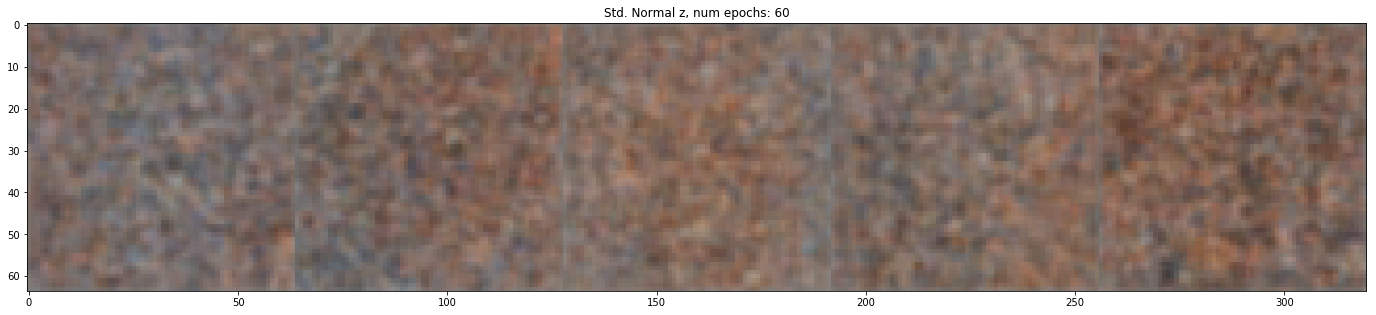

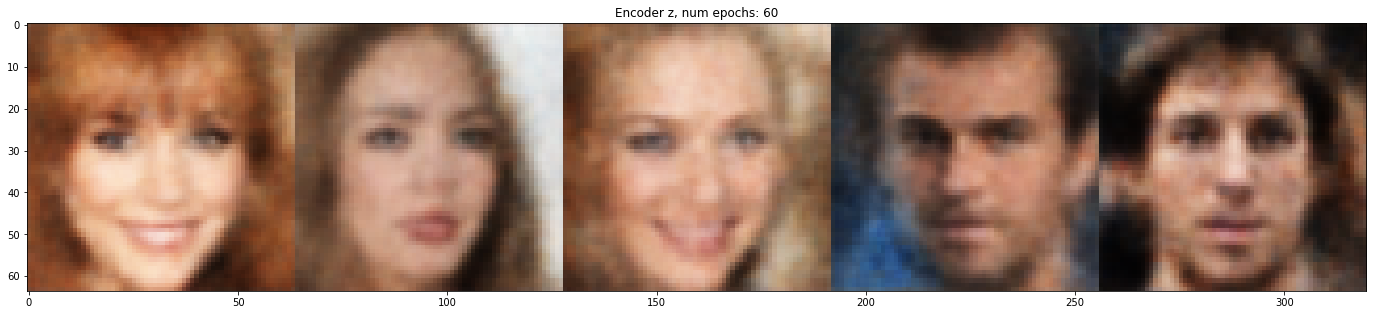

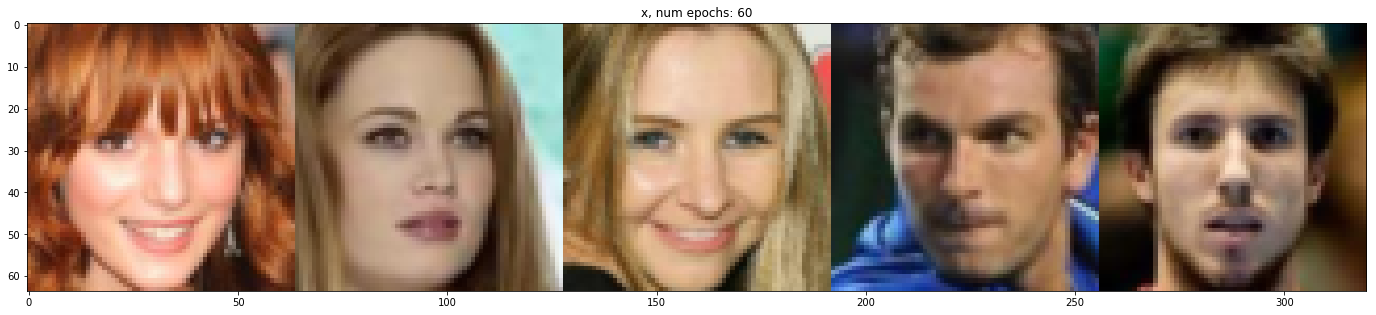

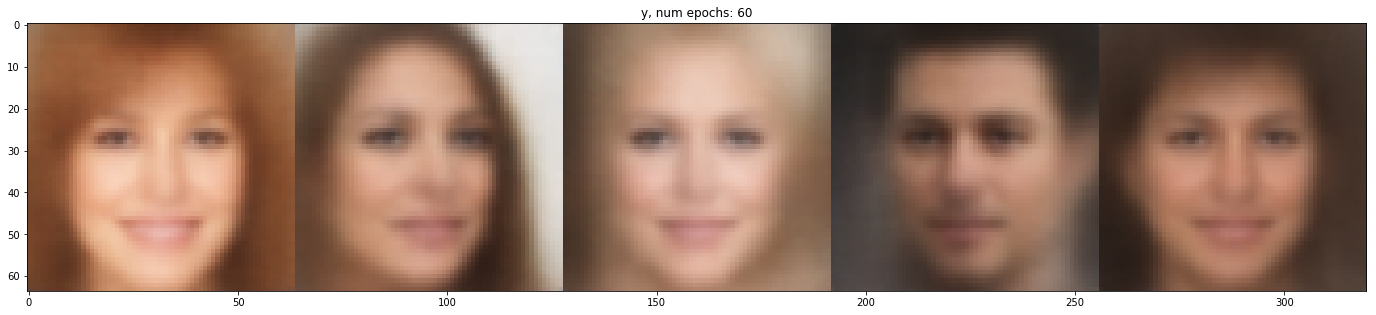

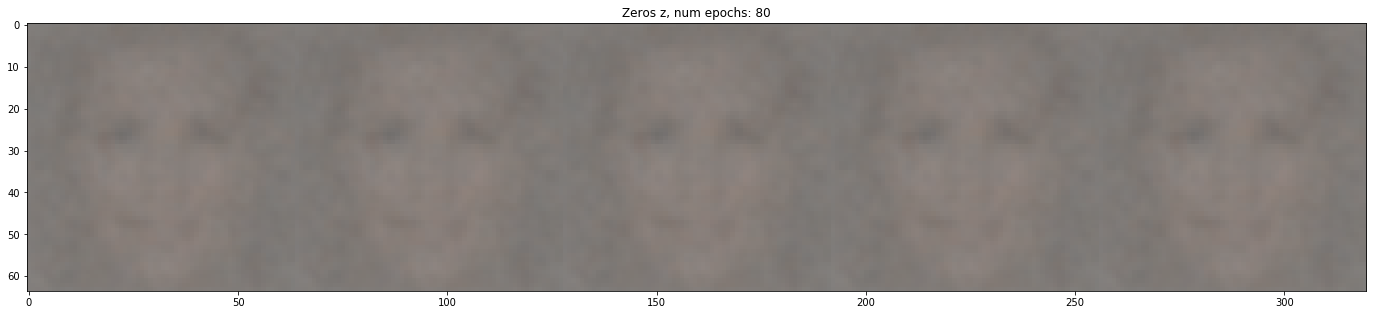

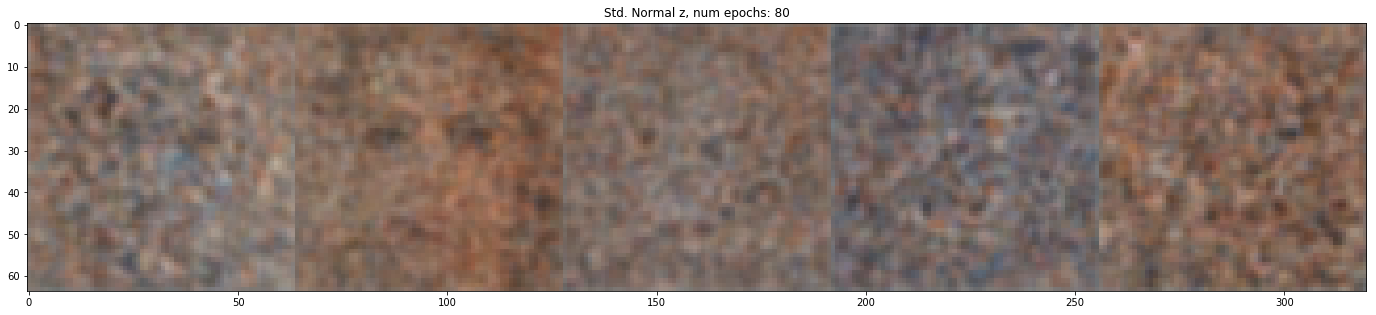

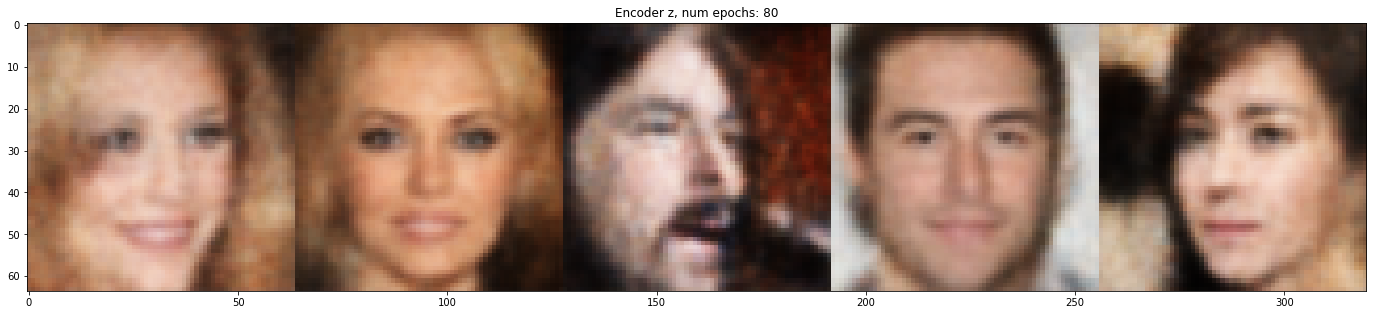

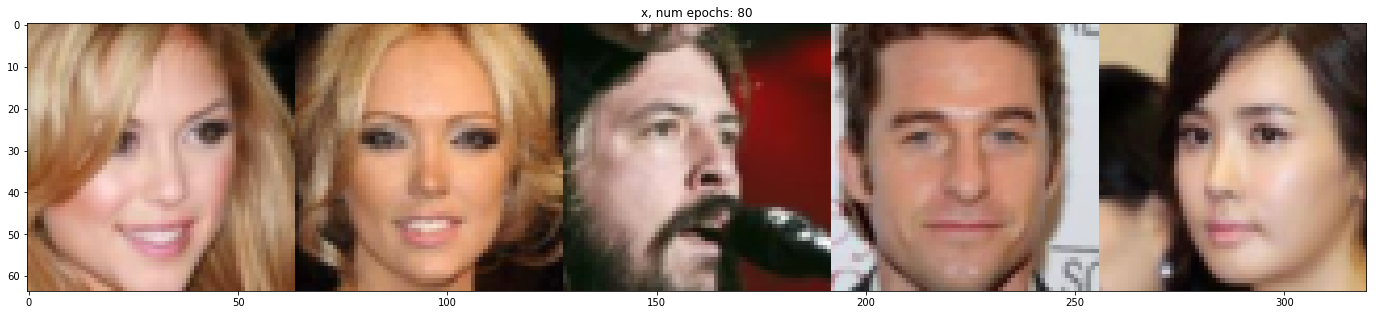

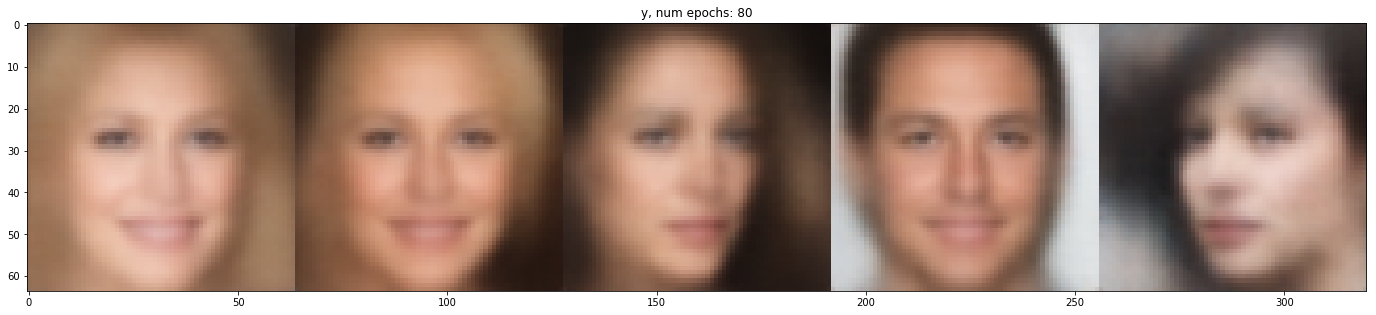

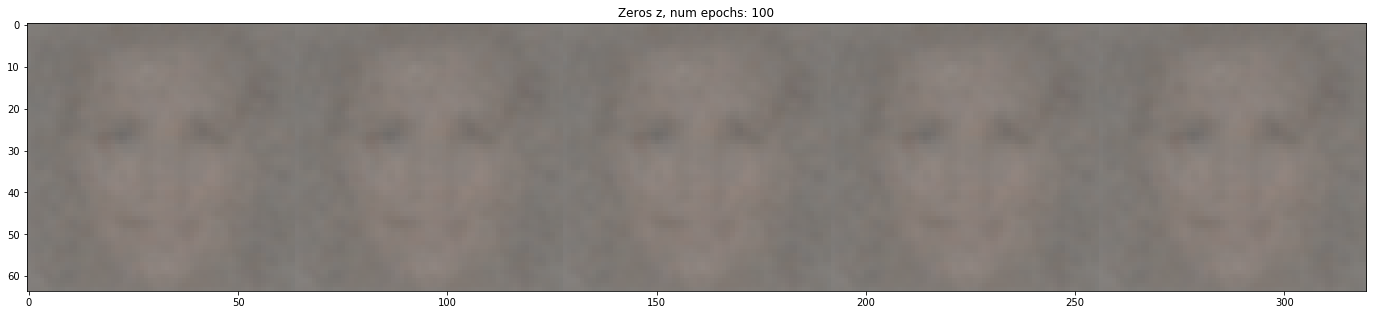

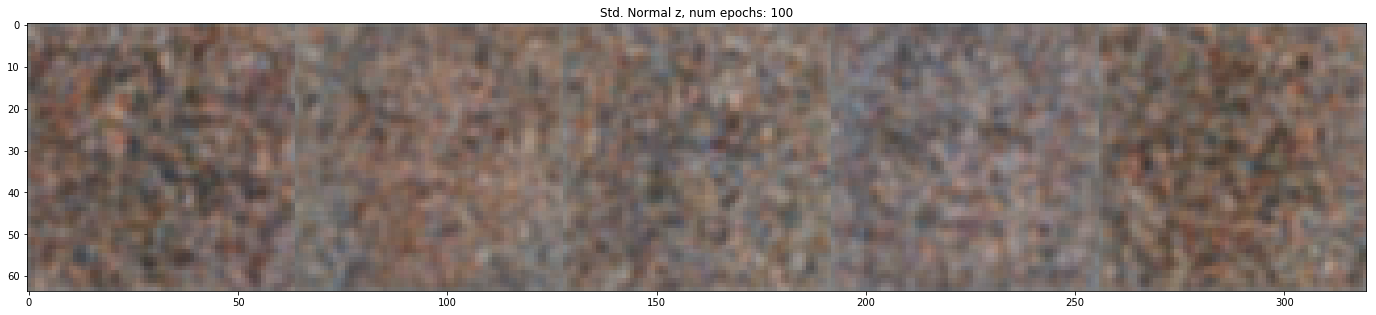

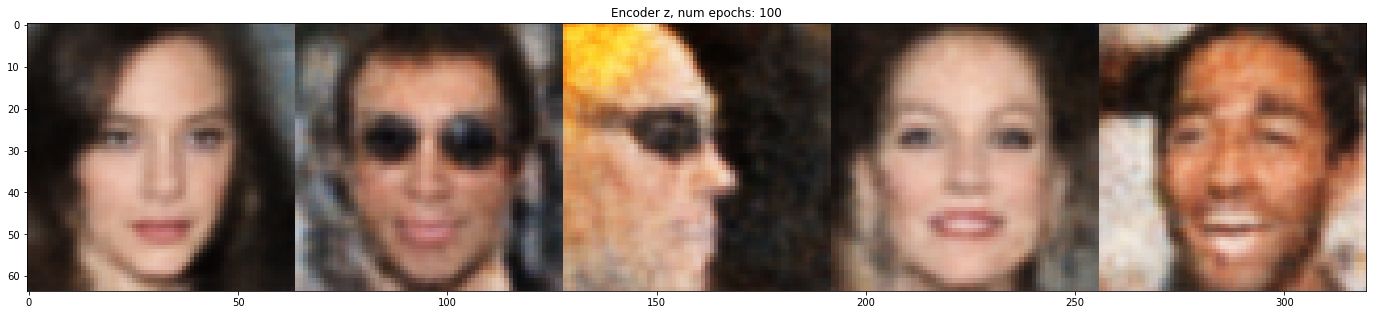

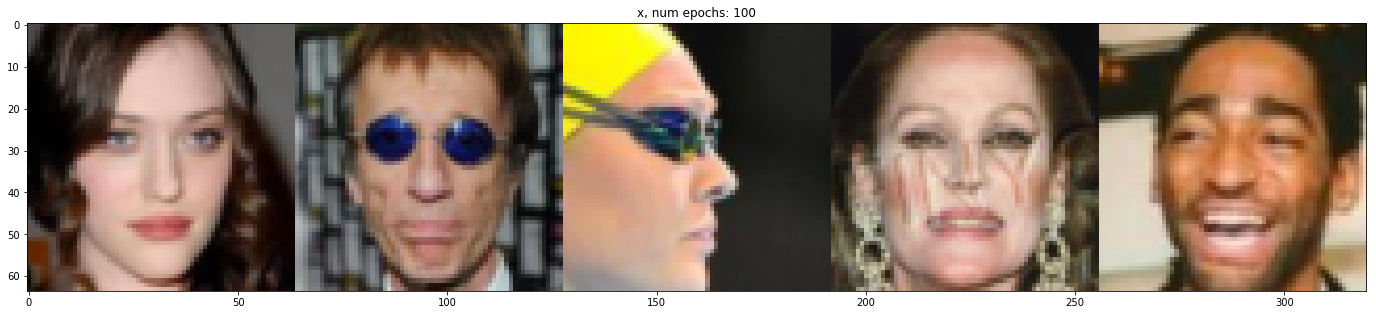

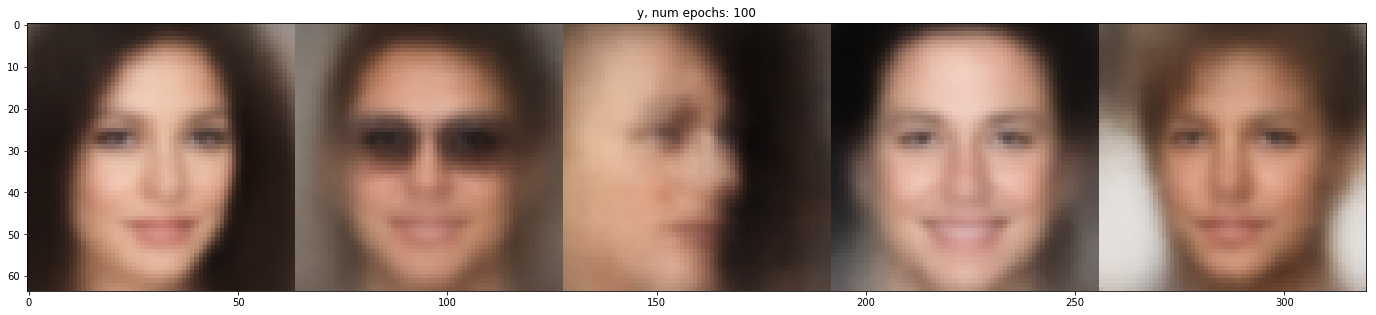

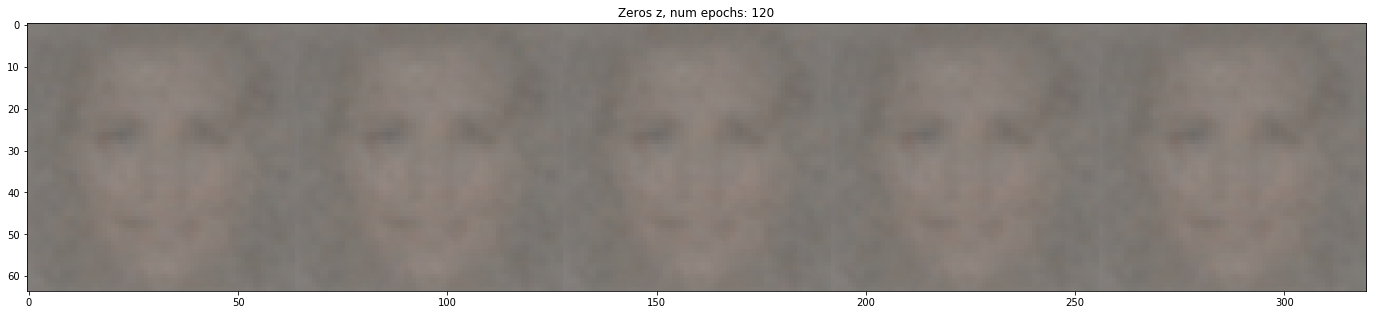

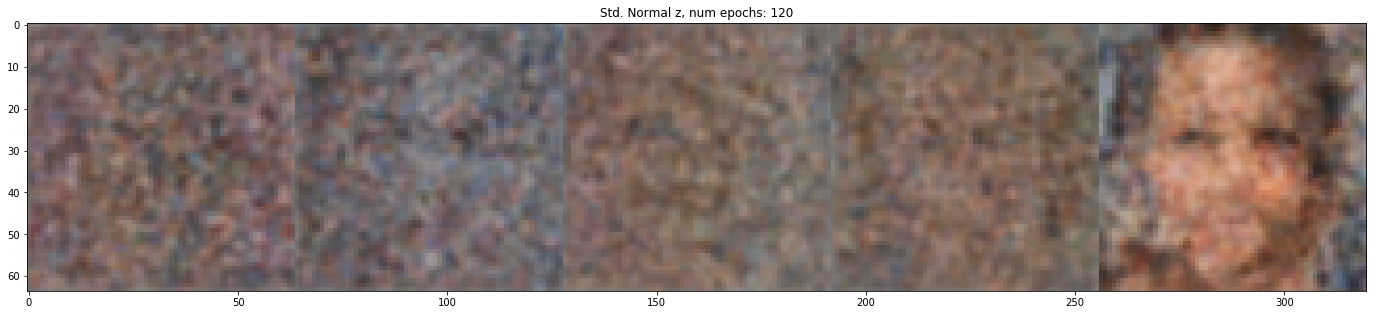

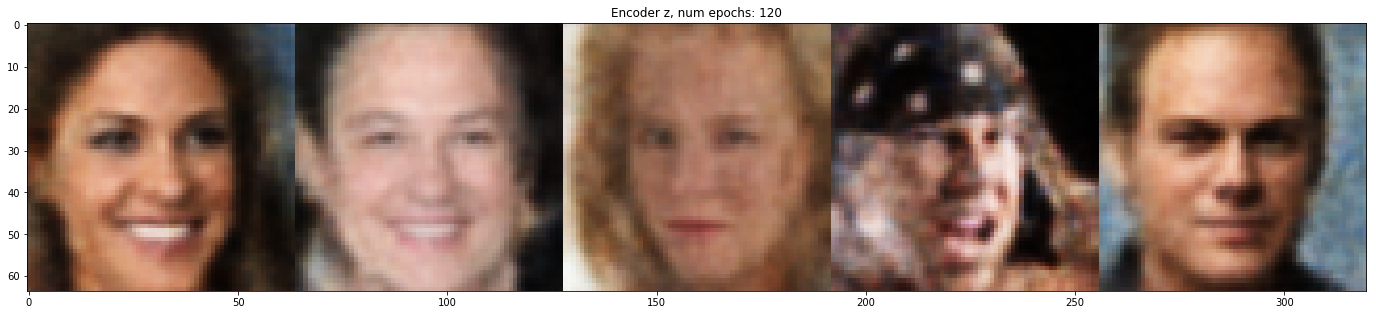

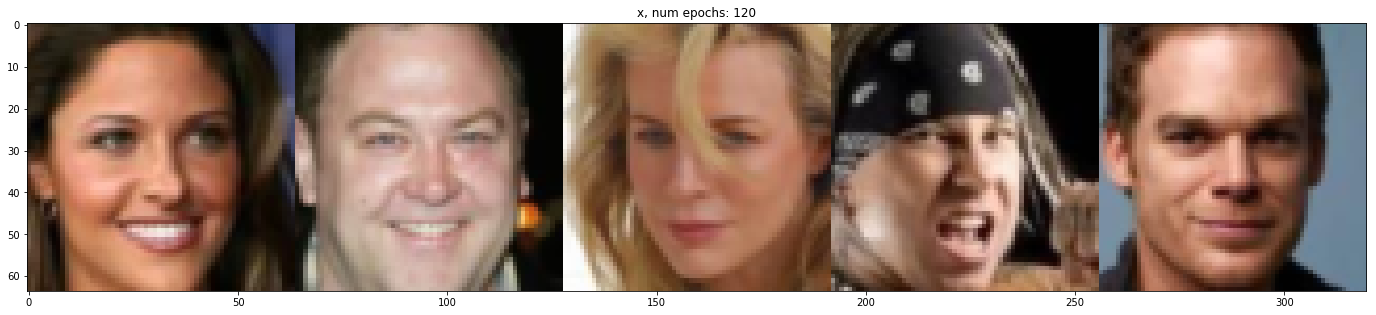

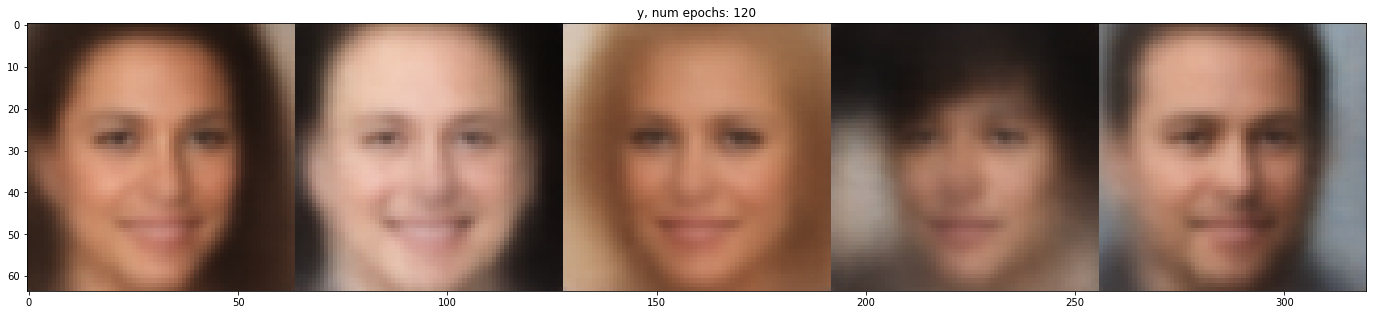

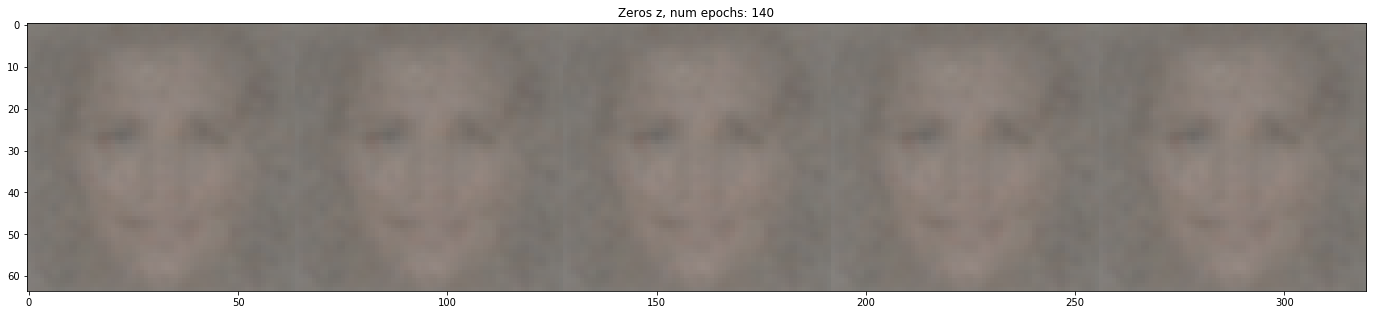

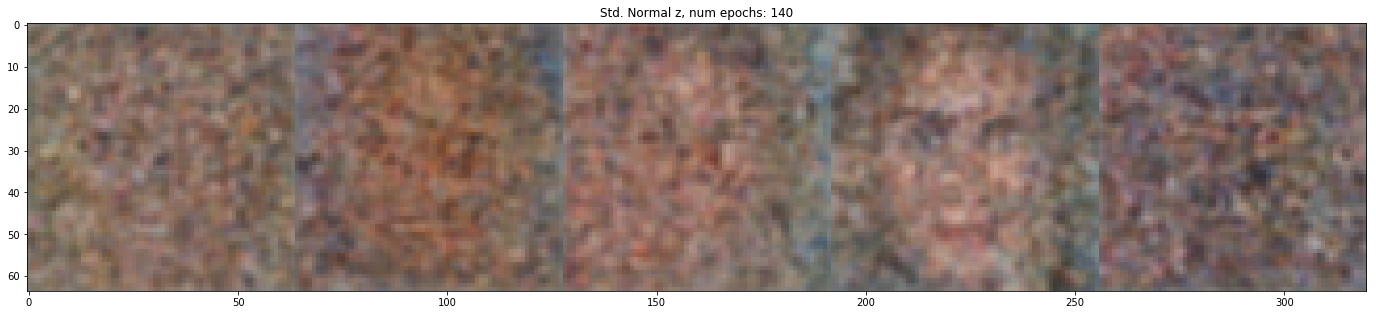

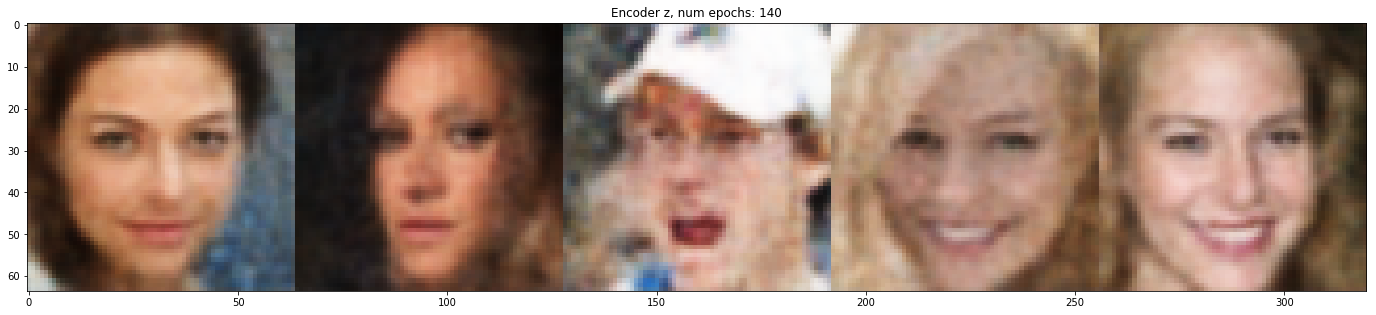

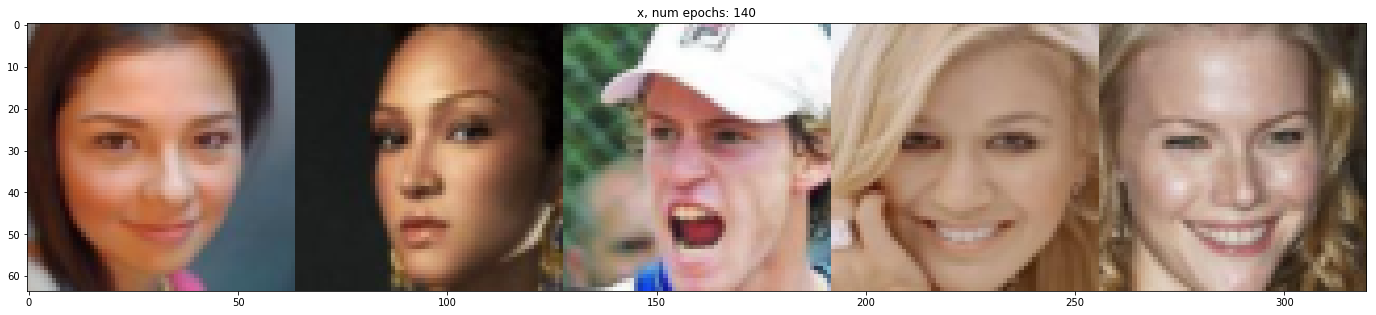

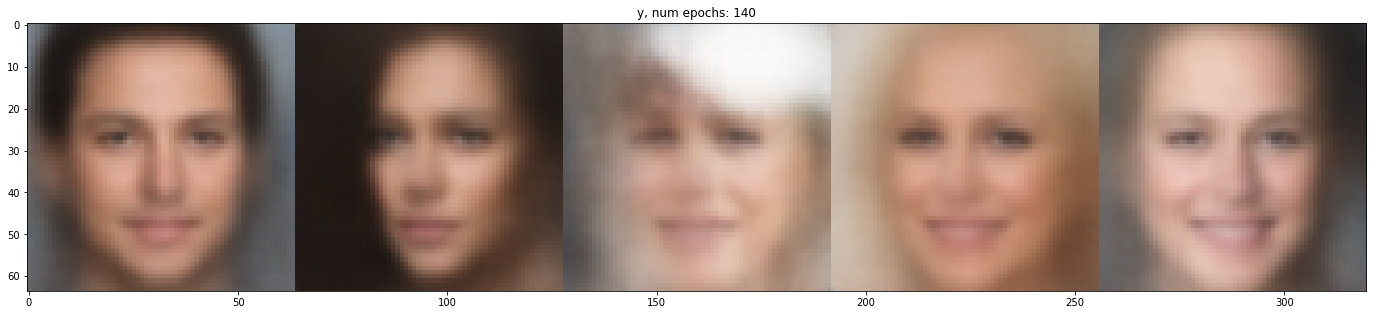

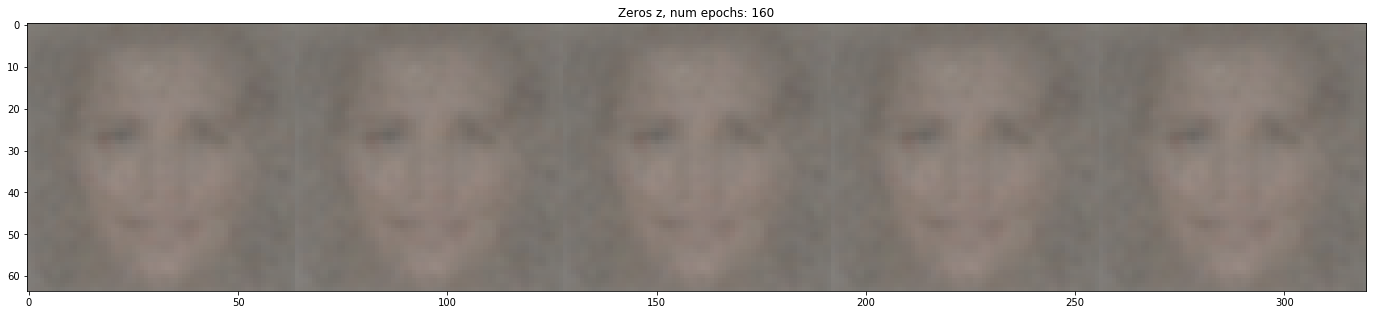

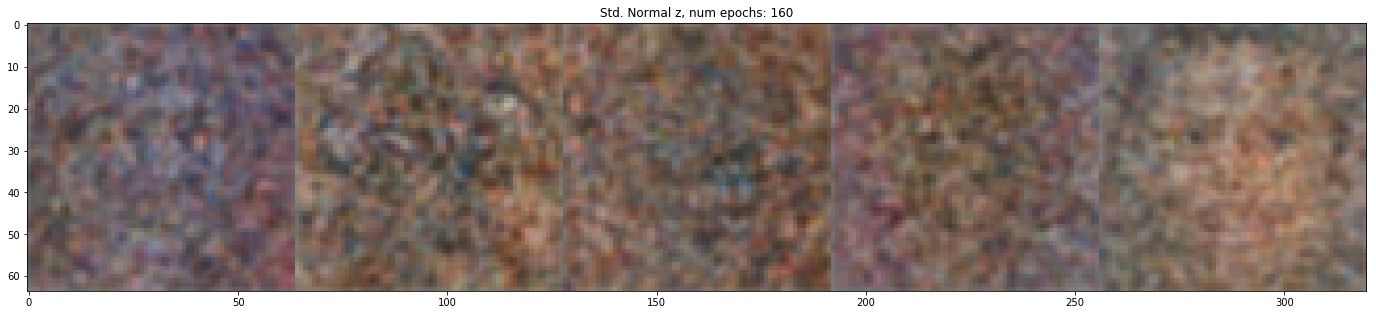

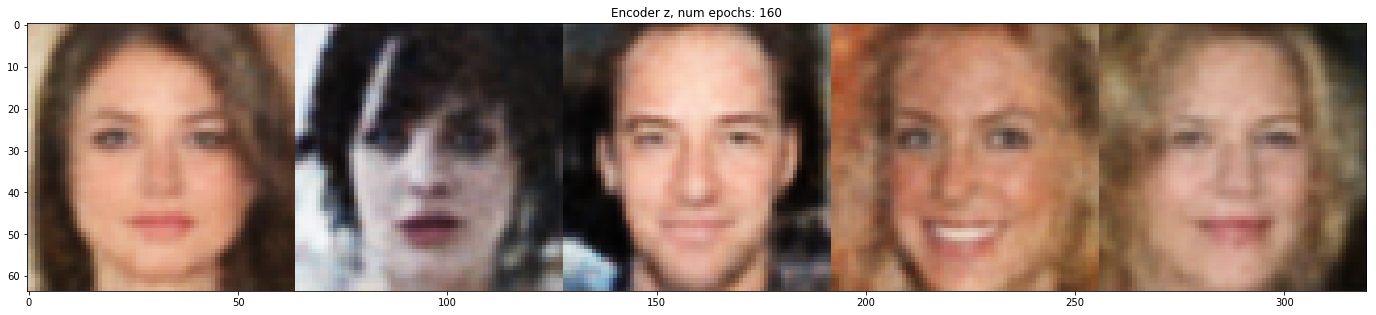

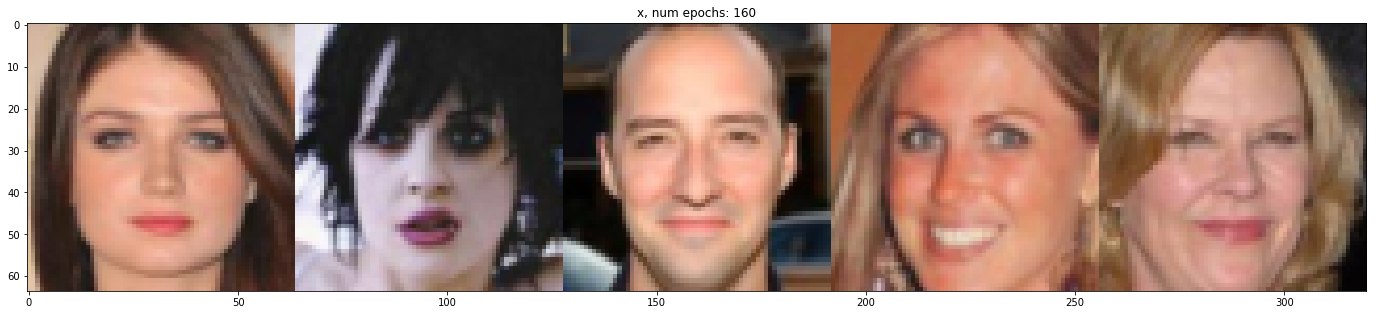

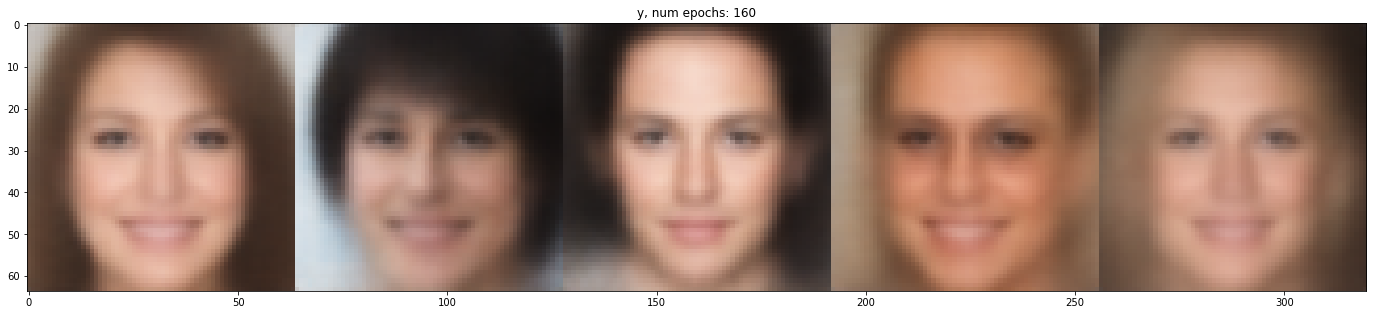

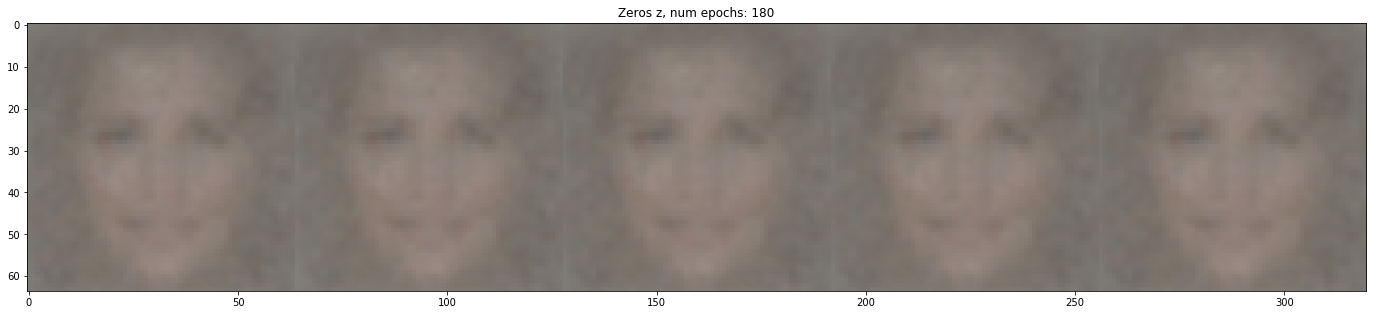

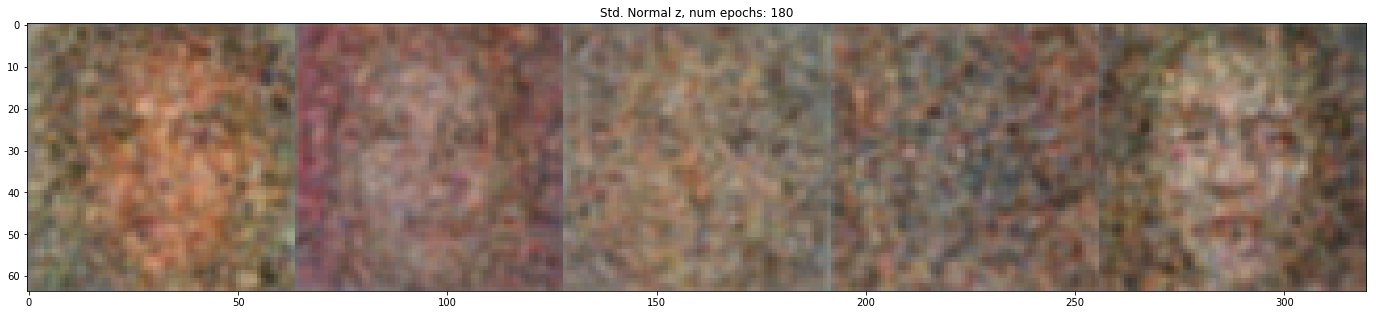

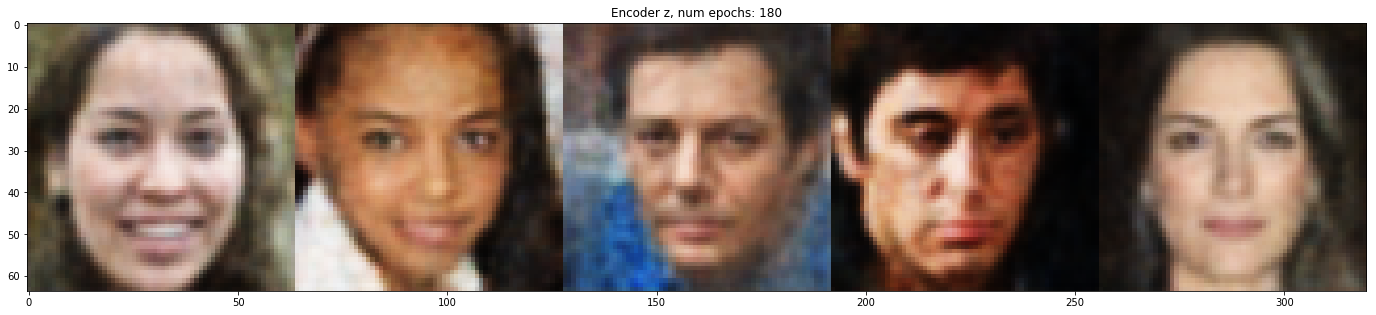

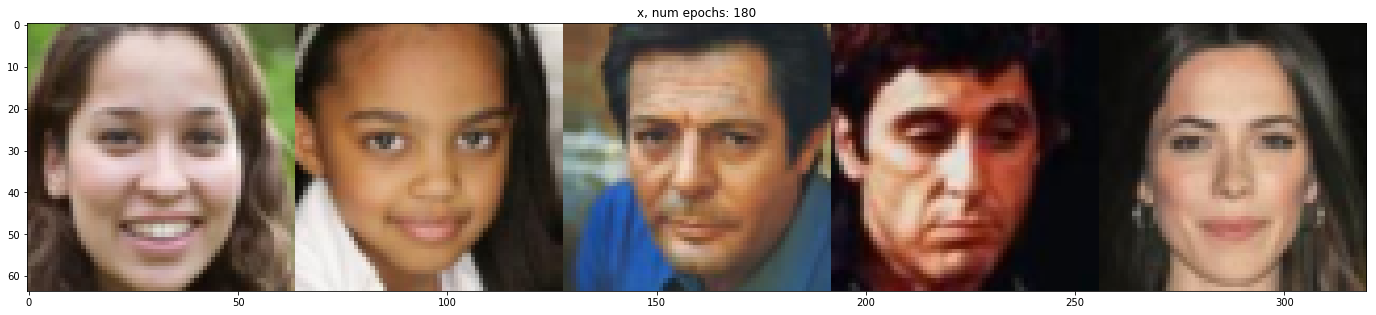

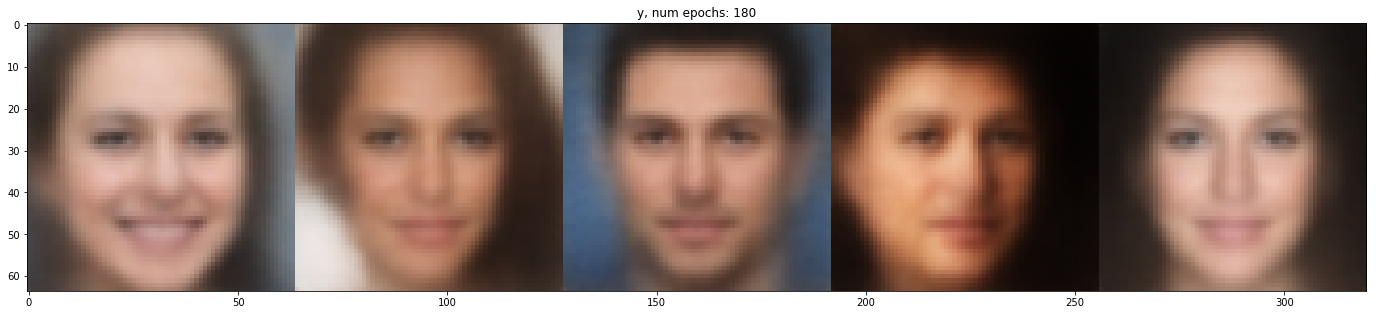

In [ ]:
dsvae.train()
normal = torch.distributions.Normal(0,1)
print("Training for {} epochs...".format(1500))
for n in range(0, 1500):
    for (i, X) in enumerate(torch_data_loader):
        x = X[0]
        y_all = X[1]
        rand_int = np.random.randint(0,num_y_samples)
        y = y_all[:,rand_int]
        if dsvae.cuda:
            x = x.to(device)
            y = y.to(device)
        optimizer.zero_grad()
        x_hat, z_mu, z_var = dsvae(x, y)
        loss, recon_loss, kl_loss = loss_function(x_hat, x, z_mu, z_var)
        if log:
            wandb.log({'loss':loss})
            wandb.log({'recon_loss':recon_loss})
            wandb.log({'kl_loss':kl_loss})
        loss.backward()
        optimizer.step()

    if n%20 ==0:
        dsvae.eval() #evaluate model
        z_noise = normal.sample((x.shape[0],85))
        z_zeros = torch.zeros((x.shape[0],85))
        if dsvae.cuda:
            z_noise = z_noise.to(device)
            z_zeros = z_zeros.to(device)
        x_hat_noise = dsvae.decode(z_noise, y)
        x_hat_zeros = dsvae.decode(z_zeros, y)
        
        fig = plot_pytorch_images(x_hat_zeros[:5], num_images=5, title='Zeros z, num epochs: {}'.format(n))
        if log:
            wandb.log({'Zeros z':fig})
            
        fig = plot_pytorch_images(x_hat_noise[:5], num_images=5, title='Std. Normal z, num epochs: {}'.format(n))
        if log:
            wandb.log({'Std. Normal z':fig})
            
        fig = plot_pytorch_images(x_hat[:5], num_images=5, title='Encoder z, num epochs: {}'.format(n))
        if log:
            wandb.log({'Encoder z':fig})
            
        fig = plot_pytorch_images(x[:5], num_images=5, title='x, num epochs: {}'.format(n))
        if log:
            wandb.log({'x':fig})

        fig = plot_pytorch_images(torch.sigmoid(y[:5]), num_images=5, title='y, num epochs: {}'.format(n))
        if log:
            wandb.log({'y':fig})   
        dsvae.train() #back to training model